# Emotion Detection Classification - Setting up a possible depression language detector
In a text heavy communication business with the general public, such as one that has a chatbot interface, it can be important to detect patterns of depression or possible intent of self-harm in communications.  Technology has advanced to where some of this monitoring can be automated based on language patterns used. 

This project is an exploration of potential machine learning models that could detect emotions based on short text interactions.  The source of the data is a labeled set of ~40k tweets.  Initial attempts will see if unsupervised methods will result in clusters similar to the labeled categories.  Later exploratory modeling will focus on supervised learning techniques for comparison.

In [80]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy

from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


## Data source description

This dataset focuses on emotion detection from text, presenting a collection of tweets annotated with corresponding emotions. It comprises three columns: tweet_id, sentiment (emotion), and content (the raw tweet). The dataset features 40,000 records across 13 different emotions, highlighting challenges such as class imbalance and the necessity for advanced multiclass classification techniques. It is sourced from the data.world platform, where it is available under a Public License.

More information can be found: https://data.world/crowdflower/sentiment-analysis-in-text



In [4]:
# load the data
df = pd.read_csv('data/tweet_emotions.csv')

# show the first 5 rows of the data
print(df.head())

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


## Date exploratory analysis - EDA
Initial review of data, look for duplicates, analysis of labels

In [5]:
# check for duplicate data rows
print(df.duplicated().sum())

0


There are no duplicated data rows in the dataset.  Now lets review the label proportions to understand the supervised class balances

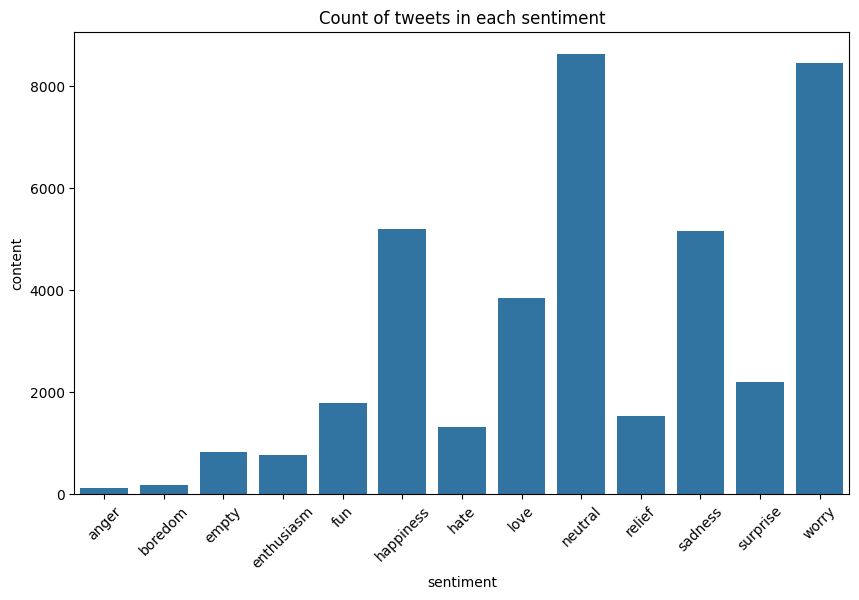

In [13]:
# group by sentiment and count the number of tweets in each sentiment
sentiment_count = df.groupby('sentiment').count()
# use seaborn to plot the count of tweets in each sentiment, sorted by count of sentiment descending
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.title('Count of tweets in each sentiment')
sns.barplot(data=sentiment_count, x=sentiment_count.index, y=sentiment_count['content'])
plt.show()


In [14]:
# check for missing values in the data
print(df.isnull().sum())

tweet_id     0
sentiment    0
content      0
dtype: int64


### EDA Summary
Analysis of data finds no missing values or duplicate rows.  Review of some records examples shows differences in lengths of text that may affect the quality of the emotion detection categorization.  We will add a feature to represent the length of the tweet.

In [15]:
# add a new column to the data that contains the length of each tweet
df['tweet_length'] = df['content'].apply(lambda x: len(x))

Review the lengths of tweets against the categories for any apparent differences between the labeled emotions.

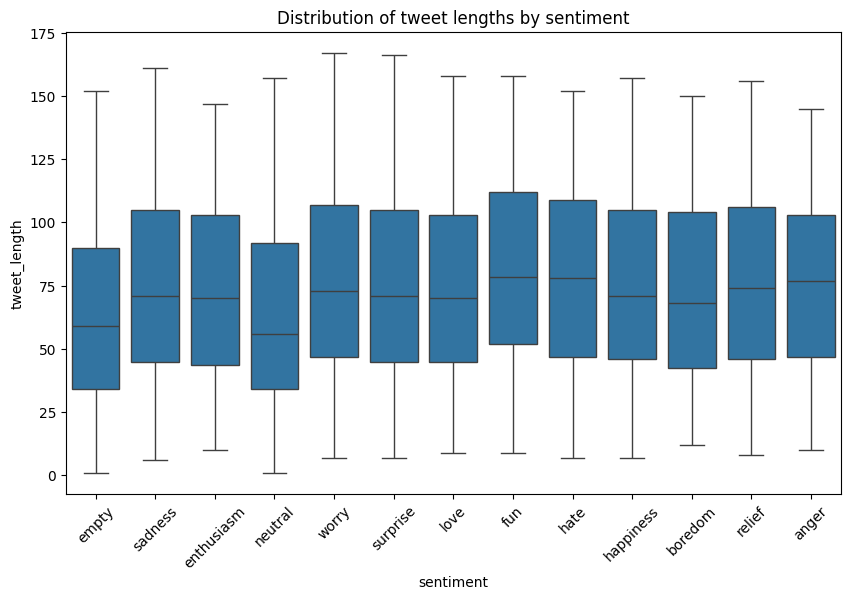

In [17]:
# use Seaborn to plot the distribution of tweet lengths by sentiment
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.title('Distribution of tweet lengths by sentiment')
sns.boxplot(data=df, x='sentiment', y='tweet_length')
plt.show()

There does not appear to be significant differences between the categories based on length.  Let's look at some statistics around negative words with goal of understanding if length of tweet has some correlation to the negativity of the tweet.

To do this, we will leverage the NLTK sentiment analysis package.  We will focus on the negativity score while ignoring the positive and compound scoring.  To do this we will use the VADER sentiment analyzer.  The VADER sentiment analyzer is a tool designed for sentiment analysis of text, particularly good at handling social media content. It uses a lexicon of words rated for positive, negative, and neutral sentiment, which are pre-scored based on their valence. Valence refers to the valence" refers to the intrinsic attractiveness or aversiveness of the word. 

VADER combines these scores with grammatical and contextual rules to calculate the sentiment of text. It accounts for factors like punctuation, capitalization, and modifiers to enhance its accuracy. The output is a compound score that indicates the overall sentiment, as well as separate scores for the positive, negative, and neutral components of the sentiment.  For this analysis, we will focus on the negative component first since the intent is to detect potential depressive indicators from language that is used.

In [30]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrewminteer/nltk_data...


True

In [31]:
# for each tweet, calculate the sentiment score using the VADER sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
#df['sentiment_score'] = df['content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['neg'])
df['negative_sentiment'] = [sentiment_analyzer.polarity_scores(x)['neg'] for x in df['content']]



Review boxplot of negative sentiment scores by emotion category.  We would expect the sad, more negative emotions to be higher.

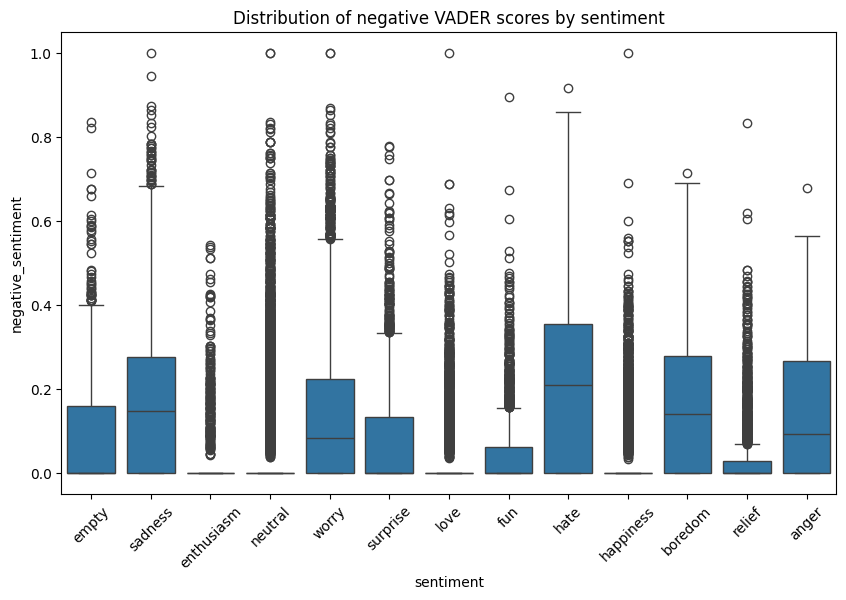

In [32]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.title('Distribution of negative VADER scores by sentiment')
sns.boxplot(data=df, x='sentiment', y='negative_sentiment')
plt.show()

The results seem to verify the expectation.  Now, let's look at the correlations between lenght of tweet and negativity

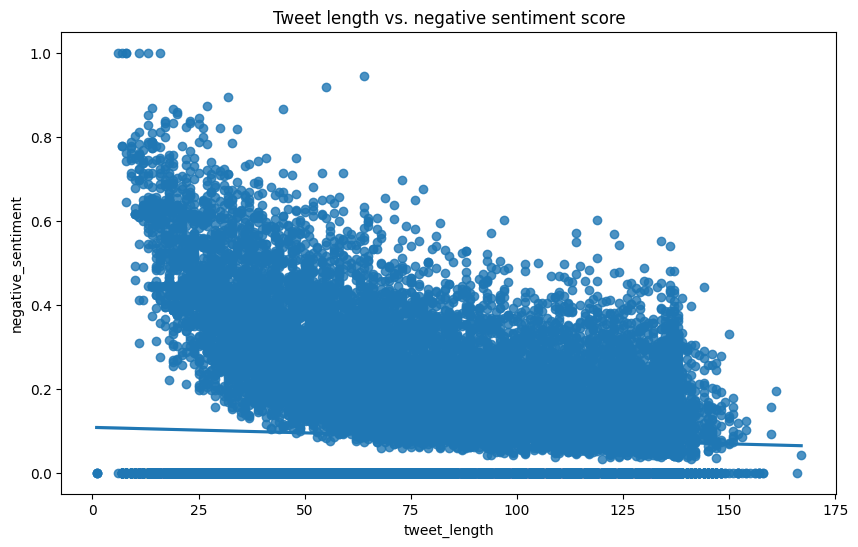

In [33]:
# create scatter plot of tweet length vs. negative sentiment score with regression line
plt.figure(figsize=(10, 6))
plt.title('Tweet length vs. negative sentiment score')
sns.regplot(data=df, x='tweet_length', y='negative_sentiment')
plt.show()

And pair plot by the sentiment category labels

<Figure size 1000x600 with 0 Axes>

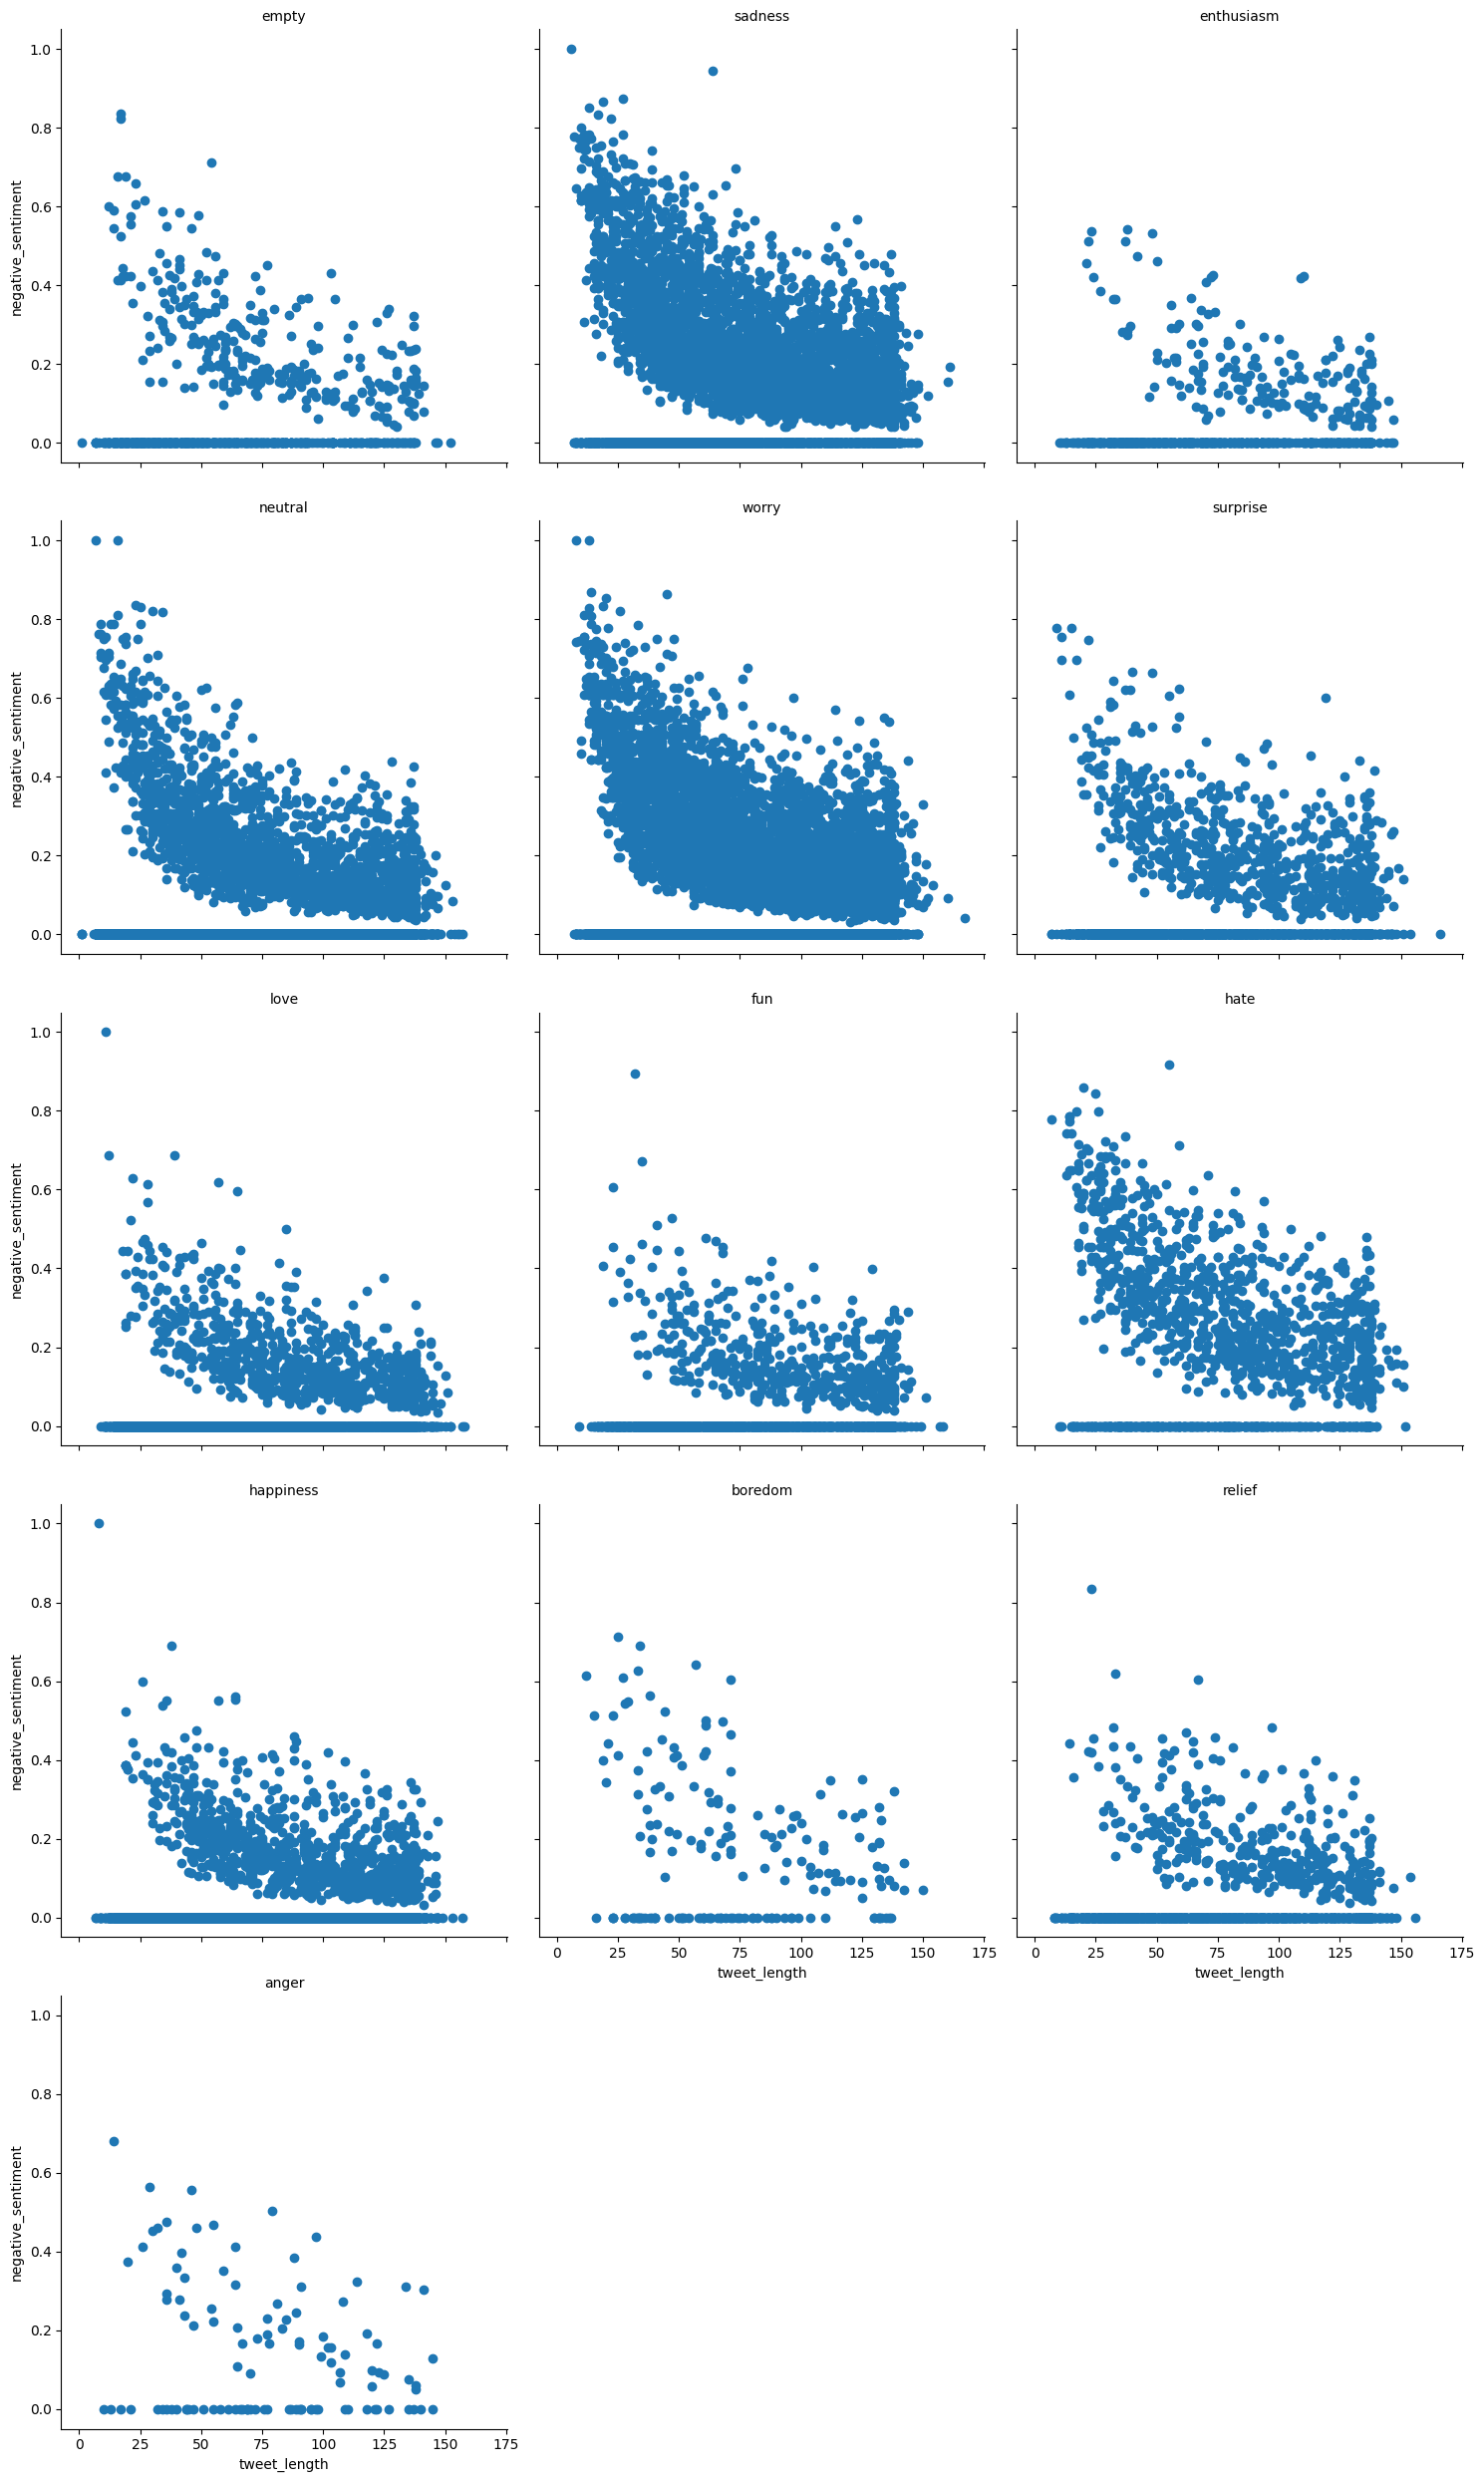

In [36]:
# # create a facet grid plot of tweet length vs negative sentiment for each sentiment category
# with sns.axes_style("white"):
#     g = sns.FacetGrid(df, row="sentiment", col="sentiment", margin_titles=True, height=2.5)
# g.map(sns.scatterplot, "tweet_length", "negative_sentiment", color="#334488")
# g.set_axis_labels("Tweet length", "Negative Sentiment score")
# g.set(xticks=[10, 100, 200], yticks=[0, 0.5, 1.0])
# g.figure.subplots_adjust(wspace=.02, hspace=.02)

# create a scatter plot in a grid chart with a facet for each sentiment category
plt.figure(figsize=(10, 6))
sns.FacetGrid(df, col='sentiment', col_wrap=3, height=5).map(plt.scatter, 'tweet_length', 'negative_sentiment').set_titles('{col_name}')
plt.show()



We will calculate the correlation score for each sentiment category as the visual is inconclusive is some cases

In [39]:
# create a table of the correlation between tweet length and negative sentiment score for each sentiment category
#correlation_table = df.groupby('sentiment')[['tweet_length', 'negative_sentiment']].corr()
correlation_table = df.groupby('sentiment').apply(lambda x: x['tweet_length'].corr(x['negative_sentiment']))
print(correlation_table)


sentiment
anger        -0.276390
boredom      -0.268495
empty        -0.022448
enthusiasm    0.095208
fun           0.057592
happiness     0.069848
hate         -0.333937
love          0.040262
neutral       0.008450
relief        0.060704
sadness      -0.252323
surprise      0.005722
worry        -0.172403
dtype: float64


/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/2717177528.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_table = df.groupby('sentiment').apply(lambda x: x['tweet_length'].corr(x['negative_sentiment']))


Review of the correlations does show a negative correlation between tweet lenght and the VADER negative sentiment score for anger, boredom, hate, sadness, and worry categories.  Negative correlation is the shorter the tweet, the more correlated to higher VADER score.  Some of this could be due to how the VADER sentiment analyzer works, but is useful information to keep in mind.

### Tokenization and vectorizing text to prepare for unsupervised modeling
We will first use some transformation in order to support NLP methods, such as TF-IDF (Term Frequency - Inverse Document Frequency).  The method will break apart text into tokens (word-like fragments) and put into a 1/0 vector to allow distance measures and clustering methods.  The first step is to prepare text and clean text. TF-IDF is a bag of words model that looks at the words without taking into consideration the order or positioning.

In [43]:
# create train test split records to hold out a testing set for later use
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'sentiment'], df['sentiment'], random_state = 0)

In [44]:
# need to download the spacy model
!python -m spacy download en_core_web_sm

227919.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [45]:
# load some key datasets and stopwords
sp_process = spacy.load("en_core_web_sm")
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andrewminteer/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewminteer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


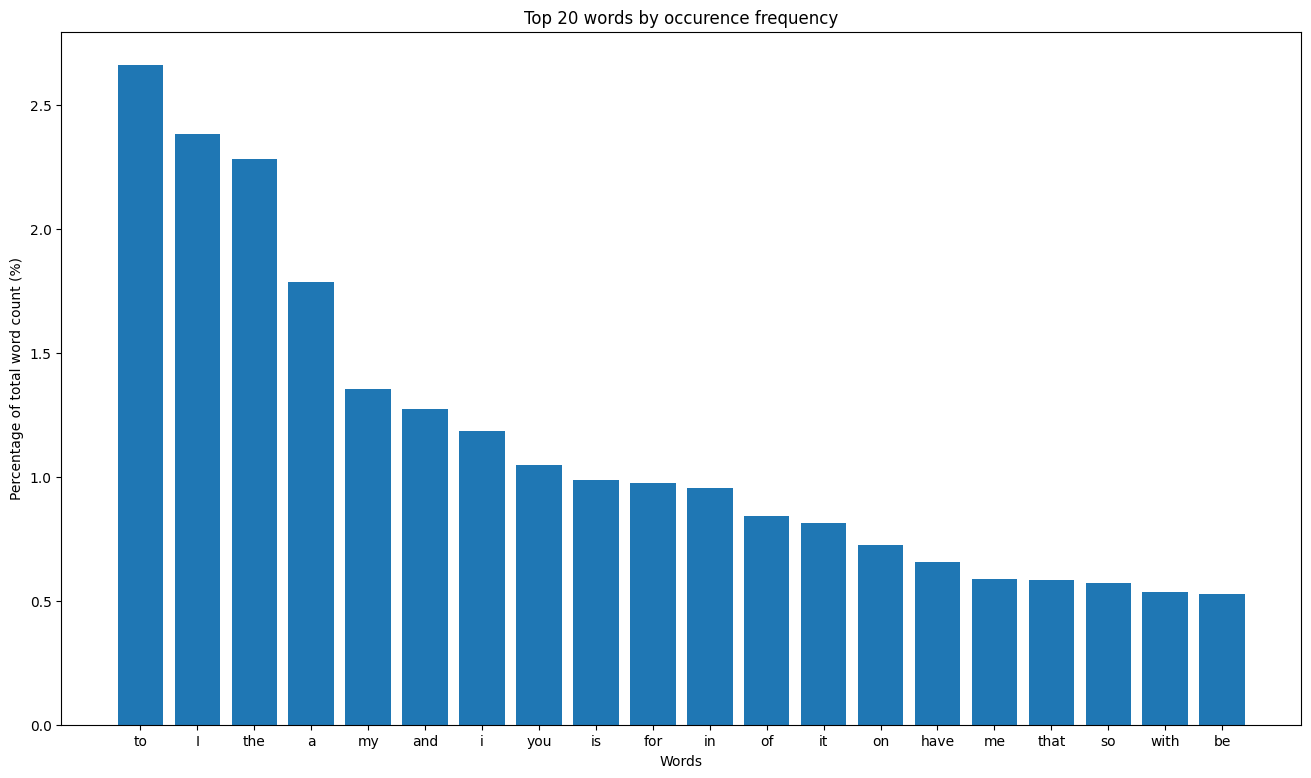

In [46]:
# Plot top 20 words by frequency
words = X_train['content'].str.split(expand=True).unstack().value_counts()
l = words[:20]/np.sum(words)*100
plt.figure(figsize=(16,9))
plt.bar(l.index, l.values)
plt.xlabel('Words')
plt.ylabel('Percentage of total word count (%)')
plt.title('Top 20 words by occurence frequency')
plt.show()

The top words are very shot, common, and informative.  Let's do a cleanup and focus more on the higher information value words/tokens.

In [47]:
# create function to preprocess text

def preprocess_text(text):
    # make text lowercase
    text = text.lower()
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # do lemmatization
    text = ' '.join([word.lemma_ for word in sp_process(text)])
    # stemming
    PorterStemmer = nltk.stem.PorterStemmer()
    text = ' '.join([PorterStemmer.stem(word) for word in text.split()])
    return text

In [48]:
# process the train data
train_preprocessed_data = X_train.copy()
train_preprocessed_data['content'] = train_preprocessed_data['content'].apply(preprocess_text)

# process the test data (for later use)
test_preprocessed_data = X_test.copy()
test_preprocessed_data['content'] = test_preprocessed_data['content'].apply(preprocess_text)

Review the cleaned up and processed top words

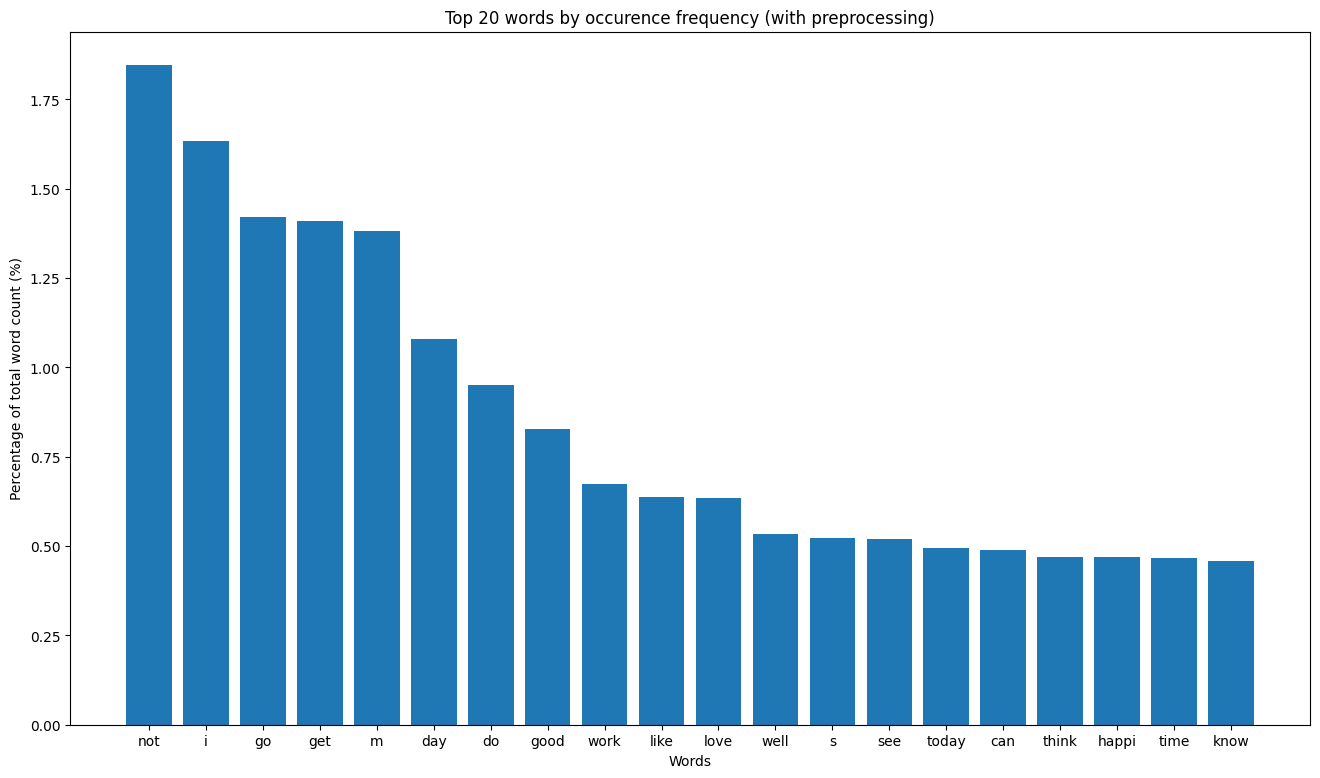

In [49]:
words = train_preprocessed_data['content'].str.split(expand=True).unstack().value_counts()
l = words[:20]/np.sum(words)*100
plt.figure(figsize=(16,9))
plt.bar(l.index, l.values)
plt.xlabel('Words')
plt.ylabel('Percentage of total word count (%)')
plt.title('Top 20 words by occurence frequency (with preprocessing)')
plt.show()

In [78]:
# add factor for category_id
# train_preprocessed_data['sentiment_id'] = train_preprocessed_data['sentiment'].factorize()[0]

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train_preprocessed_data.content).toarray()
labels = pd.DataFrame(y_train)

TF-IDF also provides normalization which is import for k-means clustering.  K-means clustering is spherical in shape so normalized data will lead to more accurate results.

In [54]:
# use K-means clustering to cluster the tweets into 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, )
train_preprocessed_data['cluster'] = kmeans.fit_predict(features)


In [55]:
def label_permute_compare(ytdf, yp, n=5): 
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    best_order = None
    best_accuracy = 0.0
    # generate all possible permutations of label order
    perms = itertools.permutations(range(n))
    # get labels into a grouped list
    yt_lables_grouped = ytdf.groupby(ytdf.columns[0]).size().index.tolist()
    # transform the labels dataframe into a numerical 1D array that matches to the index of the grouped list
    ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))
    
    order_accuracy = []
    
    # iterate through each
    for order in perms:
        # permute predicted labels
        perm_labels = np.array([order[label] for label in yp])
        #assume permuted labels are the ground truth
        accuracy = accuracy_score(y_true=ytdf_index_numbers,y_pred=perm_labels)
        # update best accuracy and add to order
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_order = order
        # add result to temp list
        order_accuracy.append((order, accuracy))
    
    return best_order, best_accuracy

Add function to calculate confusion matrix of predicted labels

In [56]:
def get_confusion_matrix(ytdf, yp, label_reorder=None):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns confusion matrix
    """
    # recode labels if a recode vector was provided
    if not label_reorder is None:
        yp = np.array([label_reorder[label] for label in yp])
    
    # get labels into a grouped list
    yt_lables_grouped = ytdf.groupby(ytdf.columns[0]).size().index.tolist()
    # transform the labels dataframe into a numerical 1D array that matches to the index of the grouped list
    ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))
    # create confusion matrix
    cm = confusion_matrix(y_true=ytdf_index_numbers, y_pred=yp)
    return cm

In [59]:
# get the confusion matrix for the KMeans clustering
km_order, km_accuracy = label_permute_compare(labels, kmeans.labels_, 5)
km_cm = get_confusion_matrix(labels, kmeans.labels_, km_order)

print("KMeans accuracy: ", km_accuracy)

/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/3274288603.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))
/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/2626521660.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))


KMeans accuracy:  0.038933333333333334


### Results at 5 clusters
Results at 5 clusters were not good (accuracy at ~0.04).  To get the target clusters closer to the label categories, we will adjust the target to 7 clusters to see if that improves the accuracy score.

In [67]:
# get the confusion matrix for the KMeans clustering
km_order, km_accuracy = label_permute_compare(labels, kmeans.labels_, 7)
km_cm = get_confusion_matrix(labels, kmeans.labels_, km_order)

print("KMeans accuracy: ", km_accuracy)
print("Confusion matrix: ", km_cm)

/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/3274288603.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))
/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/2626521660.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))


KMeans accuracy:  0.10173333333333333
Confusion matrix:  [[   0    0    1    3    3   71    5    0    0    0    0    0    0]
 [   0    0    1    5    2  115    9    0    0    0    0    0    0]
 [   0    0   11   27   20  557   24    0    0    0    0    0    0]
 [   0    0    5   22   39  482   27    0    0    0    0    0    0]
 [   0    0   22   59   92 1092   80    0    0    0    0    0    0]
 [   0    0  242  193  426 2856  180    0    0    0    0    0    0]
 [   0    0    2   27   37  884   71    0    0    0    0    0    0]
 [   0    0  152  132  267 2166  149    0    0    0    0    0    0]
 [   0    0  152  208  287 5563  252    0    0    0    0    0    0]
 [   0    0   79   76   92  854   58    0    0    0    0    0    0]
 [   0    0   22  160  156 3308  193    0    0    0    0    0    0]
 [   0    0   38   47   78 1409   71    0    0    0    0    0    0]
 [   0    0   57  385  298 5264  335    0    0    0    0    0    0]]


### Initial unsupervised k-means results versus the labeled data
As can be seen in the result accuracy (0.04), the initial model has very poor performance.  This is likely due to the high dimentional, sparse data nature of vectorized text data.  Increasing the cluster count to 7 improved the accuracy to ~0.10 however also led to significanlty more compute time.  To address these issues, there are a few things we do - we will start by using cosine similarity as the distance metric versus the initial default of euclidian measures.

The Scikit-learn imlementation of K-Means clustering only uses euclidean distance in the calculation.  For a similar clustering approach that can leverage cosine similarity as distance, we will apply a density based clustering method - DBSCAN.  DBSCAN does not specify the specific number of clusters as it is targeting a parameter based density grouping to identify clusters and there is no gaurantee that there are a set number of clusters that will meet those conditions in the data.  We will attempt to target 5 clusters so we can compare to the labeled data.

In [75]:
# Desired number of clusters
desired_clusters = 5
eps_values = np.linspace(0.1, 1.0, 100)  # Adjusting eps values from 0.1 to 1.0
best_eps = None
best_silhouette = -1
best_cluster_setup = None

# Iterating over range of eps values to find the best configuration
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    labels_dbs = dbscan.fit_predict(features)
    n_clusters = len(set(labels_dbs)) - (1 if -1 in labels_dbs else 0)
    if n_clusters == desired_clusters:
        silhouette = silhouette_score(features, labels_dbs)
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps
            best_cluster_setup = labels_dbs

# Output the best eps and cluster configuration found
if best_cluster_setup is not None:
    print(f"Best eps: {best_eps}")
    print(f"Silhouette Coefficient: {best_silhouette}")
    print("Cluster labels:", best_cluster_setup)
else:
    print("No configuration with the desired number of clusters found.")

Best eps: 0.6636363636363636
Silhouette Coefficient: -0.17041370644916232
Cluster labels: [0 0 0 ... 0 0 0]


The next step is to find the most likely label for each cluster.  The label_permute_compare function is used to do this.  It also returns the accuracy on the training set for the best performing label permutation.

In [79]:
# get the confusion matrix for the DBSCAN clustering
dbs_order, dbs_accuracy = label_permute_compare(labels, best_cluster_setup, 5)
dbs_cm = get_confusion_matrix(labels, best_cluster_setup, dbs_order)

print("Cosine Similarity DBSCAN accuracy: ", dbs_accuracy)

/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/3274288603.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))
/var/folders/5x/6qq01srd4dx12xk1x9v713jr0000gn/T/ipykernel_54500/2626521660.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytdf_index_numbers = np.array(ytdf.apply(lambda x: yt_lables_grouped.index(x[0]), axis=1))


Cosine Similarity DBSCAN accuracy:  0.0451


### Unsupervised Model Results Discussion
The results so far, compared to the existing labeled data, have been lower than expected.  The computational time required to increase the number of target clusters to more closely match the number of label categories is prohibitive.  Compute times of several hours was required for even a target of 5 clusters for the DBSCAN process.  Code optimization would help with this, although the low accuracy seen so far indicates it is likely not worth the investment of time.

We will attempt some supervised learning methods to see if prediction accuracy can be improved.

## Supervised Learning Methods
Using supervised learning methods, such as SVM, to explore the potentional improvements in prediction accuracy.

In [81]:
# apply a couple potential supervised learning methods to the data, SVM and Random Forest.  Use GridSearchCV to find the best hyperparameters for each model

# start with SVM
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC())
])

svm_param_grid = {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1, 1, 10]
}

# create a GridSearchCV object for the SVM model
svm_grid = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=5)
svm_grid.fit(train_preprocessed_data['content'], y_train)

# review results
print(svm_grid.best_params_)
print(classification_report(y_test, svm_grid.predict(test_preprocessed_data['content'])))


{'svm__C': 1, 'svm__gamma': 1, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        27
     boredom       0.00      0.00      0.00        47
       empty       0.00      0.00      0.00       188
  enthusiasm       0.00      0.00      0.00       184
         fun       0.09      0.00      0.01       431
   happiness       0.35      0.35      0.35      1312
        hate       0.36      0.14      0.20       302
        love       0.54      0.41      0.47       976
     neutral       0.32      0.58      0.41      2176
      relief       0.30      0.02      0.04       367
     sadness       0.40      0.19      0.25      1326
    surprise       0.17      0.01      0.02       544
       worry       0.33      0.49      0.40      2120

    accuracy                           0.35     10000
   macro avg       0.22      0.17      0.17     10000
weighted avg       0.33      0.35      0.31     1000

/Users/andrewminteer/workspace/CS5623UnsupervisedLearning/emotion_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrewminteer/workspace/CS5623UnsupervisedLearning/emotion_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrewminteer/workspace/CS5623UnsupervisedLearning/emotion_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

### SVM supervised model results discussion
With an accuracy of 0.35, there is siginificant improvement in results with SVM supervised method.  This is somewhat expected as the approach focus on learning to predict the labels based on the input features directly versus identifying clusters and then assigning the likely corresponding label, as in the unsupervised methods.

### Random Forest Supervised Learning
Utilizing a decision tree based method, Random Forest for another supervising model approach.  This will be used as a comparison.

In [82]:
# let's try Random Forest model next
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_param_grid = {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30]
}

# hyperparameter tuning for Random Forest model
rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5)
rf_grid.fit(train_preprocessed_data['content'], y_train)

# review results
print(rf_grid.best_params_)
print(classification_report(y_test, rf_grid.predict(test_preprocessed_data['content'])))

{'rf__max_depth': 30, 'rf__n_estimators': 200, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        27
     boredom       0.00      0.00      0.00        47
       empty       0.00      0.00      0.00       188
  enthusiasm       0.00      0.00      0.00       184
         fun       0.00      0.00      0.00       431
   happiness       0.39      0.19      0.25      1312
        hate       0.42      0.12      0.18       302
        love       0.55      0.40      0.46       976
     neutral       0.29      0.74      0.42      2176
      relief       0.00      0.00      0.00       367
     sadness       0.45      0.12      0.19      1326
    surprise       0.00      0.00      0.00       544
       worry       0.33      0.42      0.37      2120

    accuracy                           0.33     10000
   macro avg       0.19      0.15      0.14     10000
weighted avg       0.31      0.33   

/Users/andrewminteer/workspace/CS5623UnsupervisedLearning/emotion_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrewminteer/workspace/CS5623UnsupervisedLearning/emotion_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrewminteer/workspace/CS5623UnsupervisedLearning/emotion_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

### Random Forest results discussion
Random Forest model acheived similar accruacy as SVM after hyperparameter tuning with 0.33 accuracy.  It did perform a little worse on sadness verses SVM.  Overall, significant improvement over an unsupervised clustering methodology to align to the labeled test data.

## Conclusions
For this initial analysis, supervised learning performed better than unsupervised learning for the emotion detection use case.  Transformations of the original data to vectorize and correlation testing on the length of the social media text indicate areas for improvement.